# Exploration of the Henon Map

This files contains codes that decide whether a given (a0, b0) and (a+, b+) pair will illustrate R-tipping under a given parameter drift, with the protocol starting from s=0. 

Note: 
- (a_i, b_i) refers to the initial/start parameter pair: (a0, b0) in the zero-start protocol; or (a-, b-) in the infinite-start protocol;
- (a_f, b_f) refers to then final/end parameter pair: (a+, b+).

In [1]:
'''
Compute the stable fixed points of henon map period 1 directly with formula
Input:
    a: (float) parrameter a
    b: (float) parrameter b
Output:
    x: x-coordinate of the fixed point
    y: y-coordinate of the fixed point
'''
def direct_compute_stable_fixed_point(a, b):
    disc = max((1 - b)**2 + 4 * a, 0)
    if disc < 0 or a == 0:
        return None, None
    x_fp = (-(1 - b) + np.sqrt(disc)) / (2 * a)
    y_fp = b * x_fp
    return x_fp, y_fp

## Tip or Track
Codes to decide whether a given (a0, b0) and (a+, b+) will tip or track under the linear parameter dift (Eq.(13)) Lambda with a rate r

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator

In [3]:
'''
linear path of the zero-start protocol
'''
def linear_path0(a_i, b_i, a_f, b_f, s_temp):
    a = a_i + (a_f - a_i) * np.tanh(s_temp)
    b = b_i + (b_f - b_i) * np.tanh(s_temp) 
    
    return a, b  


"""
Compute the next value of the henon map, with detection whether any orbit goes to infinity
Input:
    a: (float) parrameter a
    b: (float) parrameter b
    x_current: (float) the current value of x
    y_current: (float) the current value of y
    infinity_tipping_detected: (bool) whether it detects values go to infinity
    MAX_VAL: (float) threshold to indicate the mao is going to infinity
Output:
    x_next: (float) the next value of x
    y_next: (float) the next value of y
"""
def henon_map_next(a, b, x_current, y_current, MAX_VAL, infinity_tipping_detected): 
    x_next = 1 - a * x_current**2 + y_current
    y_next = b * x_current

    # Works with both scalar and array input
    overflow = (
        ~np.isfinite(x_next) | ~np.isfinite(y_next) |
        (np.abs(x_next) > MAX_VAL) | (np.abs(y_next) > MAX_VAL)
    )
    
    if np.any(overflow):
        x_next = np.where(overflow, np.nan, x_next)
        y_next = np.where(overflow, np.nan, y_next)
        infinity_tipping_detected = True

    return x_next, y_next, infinity_tipping_detected


'''
Input a value of r, see whether the system will tip with the given functions from (a_i, b_i) to (a_f, b_f)
Output:
    True: if the input r value inducing tipping to inifinity
    False: if not
    None: ambiguous case, tip to other orbits
'''
def r_inducing_tipping(func, a_i, b_i, a_f, b_f, r, x0, y0, 
                       N=1500, MAX_VAL=1e4, div_steps=60, diverge_threshold=1e-2,
                       converge_threshold=1e-4, converge_steps=30):
    
    min_steps = min(N-converge_steps, N-div_steps)

    x, y = x0, y0
    dist_ls = []
    escaped = False
    # N_prev = 15    # for the infinite-start protocol, decide by a test round
    N_prev = 0 # zero-start protocol 0
    for n in range(-N_prev, N):
        if np.isinf(r):
            a, b = a_f, b_f
        else:
            s_temp = r * n
            a, b = func(a_i, b_i, a_f, b_f, s_temp)
            
        x, y, escaped = henon_map_next(a, b, x, y, MAX_VAL, escaped)
        if escaped or not np.isfinite(x) or not np.isfinite(y):
            return True

        x_fp, y_fp = direct_compute_stable_fixed_point(a, b)
        if x_fp is None and y_fp is None:
            continue

        dist = np.hypot(x - x_fp, y - y_fp)
        if not np.isfinite(dist) or dist > MAX_VAL:
            return True
        
        # ignore earlier steps
        if n < min_steps:
            continue
        
        dist_ls.append(dist)
        
    # Check convergence
    if len(dist_ls) >= converge_steps:
        recent = np.array(dist_ls[-converge_steps:])
        if all(d < converge_threshold for d in recent):
            return False # strict convergence - so r does not induced tipping

        k = converge_steps // 3
        if k >= 3:
            is_converging = (
                np.mean(recent[0:k]) > np.mean(recent[k:2*k]) > np.mean(recent[2*k:])
            )
            if is_converging:
                return False
            
    # Check divergence  
    if len(dist_ls) >= div_steps:
        recent = np.array(dist_ls[-div_steps:])
        
        # just in case it moves away and then come back
        if k >= 3: # too few points to decide
            m1 = np.mean(recent[0:k])
            m2 = np.mean(recent[k:2*k])
            m3 = np.mean(recent[2*k:])
            all_large = (
                m1 > diverge_threshold and
                m2 > diverge_threshold and
                m3 > diverge_threshold
            )
            margin, factor = 1.05, 2
            strickly_increasing = (m1 * margin < m2) and (m2 * margin < m3)
            overall_increase = m3 > factor * m1
            if all_large and strickly_increasing and overall_increase:
                return True

    return None

In [4]:
if __name__ == "__main__":
    a_i, b_i = 0.2, 0.25 # protocol 0
    a_f, b_f = 1.38, -0.54
    r_ls = [1.5, 3.5, float('inf')]

    x0, y0 = direct_compute_stable_fixed_point(a_i, b_i)

    for r in r_ls:
        is_tipping = r_inducing_tipping(linear_path0, a_i, b_i, a_f, b_f, r, x0, y0)
        if is_tipping is True:
            result = 'tip to infinity'
        elif is_tipping is False:
            result = 'track'
        elif is_tipping is None:
            result = 'tip to other orbits'
        print(f'''
        (a0, b0) = ({a_i}, {b_i}), (a+, b+) = ({a_f}, {b_f}), r = {r}:
        {result}\n
        ''')


        (a0, b0) = (0.2, 0.25), (a+, b+) = (1.38, -0.54), r = 1.5:
        track

        

        (a0, b0) = (0.2, 0.25), (a+, b+) = (1.38, -0.54), r = 3.5:
        tip to infinity

        

        (a0, b0) = (0.2, 0.25), (a+, b+) = (1.38, -0.54), r = inf:
        tip to infinity

        


## Boundary Labels
Give a set of boundary points (basin, parameter space, rate space), figure out all the labels, so that we can visualise the phi dependence 

In [5]:
from matplotlib.colors import ListedColormap

In [6]:
'''
Find out the label('tipping', 'converge', 'ambiguous') of the given (a_f, b_f) for the parameter space:
    - assume r is infty
    - iterate (x_i, y_i) once to get (x_i^*, y_i^*)
    - see whether (x_i^*, y_i^*) is in the basin of attraction of (a_f, b_f)
Input:
    x_i, x_i: (float) the initial fixed point from the fixed (a_i, b_i)
    x_f, y_f: (float) the fixed point from (a_f, b_f)
    a_i, b_i: (float) the initial fixed (a_i, b_i)
    a_f, b_f: (float) the chose (a_f, b_f)
Output:
    None: no label found because (x_f, y_f) contains None
    0: this is a tipping situation to the infinity
    1: a converge situation
    -1: an ambiguous situation
'''
def find_label_numeric_para(x_i, y_i, x_f, y_f, a_i, b_i, a_f, b_f):
    label = None 
   
    # a_star = (a_i+a_f)/2 # protocol -infty
    # b_star = (b_i+b_f)/2 

    a_star = a_i # protocol 0
    b_star = b_i

    MAX_VAL = 1e6       
    infinity_tipping_detected = False    
    x_i_star, y_i_star, infinity_tipping_detected = henon_map_next(a_star, b_star, x_i, y_i, MAX_VAL, infinity_tipping_detected)
    if infinity_tipping_detected:
        label = 0
        return label
    
    r = float('inf')
    x_i, y_i = direct_compute_stable_fixed_point(a_i, b_i)
    induce_tipping = r_inducing_tipping(linear_path0, a_i, b_i, a_f, b_f, r, x_i, y_i)

    if induce_tipping is True:
        label = 0  

    elif induce_tipping is False:
        label = 1
    
    elif induce_tipping is None:
        label = -1
    
    return label

'''
Figure out the track/tip numerical labels of the values in the given val_space for plotting
Input:
    val_space: a list of values of in the free parameter space
    val_fixed: the fixed parameter
    x_i, y_i: input (x_i, y_i) from the selected (a_i, b_i)
    a_i, b_i: input selected (a_i, b_i)
    a_f, b_f: input selected (a_f, b_f)
output:
    labels: a list of label which contains
        - 0: tipping
        - 1: track/converge to given fixed point
        - -1: ambiguous
'''
def find_numeric_label_ls(val_space:list, val_fixed: float, 
                          x_i:float, y_i:float, 
                          a_i:float, b_i:float, a_f:float, b_f:float,
                          g_type:str):

    labels = []
    for val in val_space:
        
        if g_type == 'para':
            x_f, y_f = direct_compute_stable_fixed_point(val, val_fixed) 
            if None in (x_f, y_f):
                    continue
            label = find_label_numeric_para(x_i, y_i, x_f, y_f, a_i, b_i, val, val_fixed)
                   
        elif g_type == 'basin':
            x_f, y_f = direct_compute_stable_fixed_point(a_f, b_f) 

            r = float('inf')
            x_i, y_i = direct_compute_stable_fixed_point(a_i, b_i)
            induce_tipping = r_inducing_tipping(linear_path0, a_i, b_i, a_f, b_f, r, val_fixed, val)
            if induce_tipping is True:
                label = 0
            elif induce_tipping is False:
                label = 1
            elif induce_tipping is None:
                label = -1
        
        elif g_type == 'r':
            induce_tipping = r_inducing_tipping(linear_path0, a_i, b_i, a_f, b_f, val, x_i, y_i)  
            if induce_tipping is True:
                label = 0   
            elif induce_tipping is False:
                label = 1   
            elif induce_tipping is None:
                label = -1

        labels.append(label)

    return labels

'''
Plot heat map of fractal branch cut with input data labels. 0 - tipping to infinity (green); 1 - converge (pink)
Input:
    labels: (list or array) The label values. 0 - converge; 1 - tip to infinity
    val_min, val_max: (float) the range limit of the free parameter
    ax: (matplotlib.axes.Axes) Optional. If provided, plot into this axes. Otherwise a new figure is created.
Output:
    fig, ax : Figure and Axes objects
'''
def plot_frac_bar(labels, val_min, val_max, ax=None):
    # cmap = ListedColormap(['orange', 'darkseagreen', 'mistyrose'])
    cmap = ListedColormap(['orange', 'yellow', 'blue'])
    # cmap = ListedColormap(['whitesmoke', 'whitesmoke', 'whitesmoke'])

    ax.imshow([labels],
              aspect="auto",
              interpolation="nearest",
              vmin=-1, vmax=1, # 0 maps to the yellow (tipping/not converge), and 1 map to blue (track)
              cmap=cmap,
              extent=[val_min, val_max, 0, 1])

    ax.set_yticks([])

    return ax

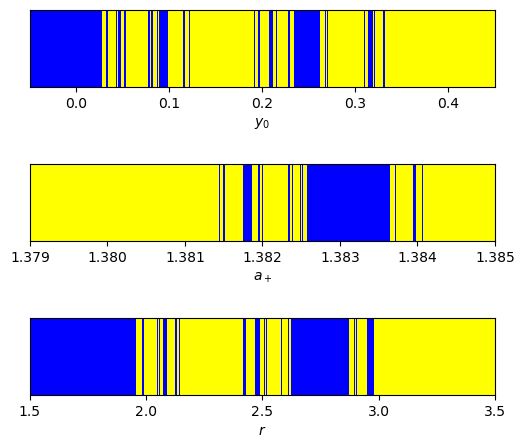

In [7]:
if __name__ == "__main__":
    a_i, b_i = 0.2, 0.25 # protocol 0
    a_f, b_f = 1.38, -0.54 #fractal
    # a_f, b_f = -0.68, -0.75 #smooth

    # RESOLUTION = 30000
    RESOLUTION = 1000

    x_i, y_i = direct_compute_stable_fixed_point(a_i, b_i) 

    # --- plot the heat maps bar ---
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 5), gridspec_kw={'hspace': 1}, squeeze=False)
    
    ax_basin = axes[0, 0]
    ax_para = axes[1, 0]
    ax_r = axes[2, 0]

    # --- basin --- 
    x_fixed = -0.2 # fractal
    y_min, y_max = -0.05, 0.45 
    
    # x_fixed = 0.5 # smooth
    # y_min, y_max = -0.12, 0 

    y_space = np.linspace(y_min, y_max, RESOLUTION)
    labels_basin = find_numeric_label_ls(y_space, x_fixed, 
                                        x_i, y_i,
                                        a_i, b_i, a_f, b_f, 
                                        'basin')    

    ax_basin = plot_frac_bar(labels_basin, y_min, y_max, ax=ax_basin)
    ax_basin.set_xlabel(r'$y_0$')
    # ax_basin.set_ylabel('Basin boundary\n' + r'(fixed $x$)')

    patch_out_basin = mpatches.Patch(facecolor='yellow', edgecolor='grey', linewidth=0.5, label=r'Tip to $\infty$')
    patch_in_basin = mpatches.Patch(facecolor='blue', edgecolor='grey', linewidth=0.5, label='Track')

    leg_basin = ax_basin.legend(handles=[patch_out_basin, patch_in_basin], loc="upper right", frameon=True)

    # --- Parameter Space ---
    b_fixed = -0.54 # fractal - fixed (a0,b0)
    a_min, a_max = 1.379, 1.385 #fractal


    # b_fixed = - 0.75  # smooth - fixed (a0,b0)
    # a_min, a_max = -0.7, -0.5

    a_space = np.linspace(a_min, a_max, RESOLUTION)   

    x_i, y_i = direct_compute_stable_fixed_point(a_i, b_i)  
    
    labels_para = find_numeric_label_ls(a_space, b_fixed, 
                                        x_i, y_i, a_i, b_i,
                                        a_f, b_f,  
                                        'para')

    ax_para = plot_frac_bar(labels_para, a_min, a_max, ax=ax_para)
    ax_para.set_xlabel(r'$a_+$')
    # ax_para.set_ylabel('Parameter space\n' + r'(fixed $b$)')

    patch_tipping_para = mpatches.Patch(facecolor='yellow', edgecolor='grey', linewidth=0.5, label=r'Tip to $\infty$')
    patch_converge_para = mpatches.Patch(facecolor='blue', edgecolor='grey', linewidth=0.5, label='Track')

    leg_para = ax_para.legend(handles=[patch_tipping_para, patch_converge_para], loc="upper right", frameon=True)

    # --- Rate Space ---
    r_fixed = None
    r_min, r_max = 1.5, 3.5 # smooth to fractal
    # r_min, r_max = 0.2, 0.44 # smooth to smooth

    r_space = np.linspace(r_min, r_max, RESOLUTION)
    labels_r = find_numeric_label_ls(r_space, r_fixed, 
                                        x_i, y_i,
                                        a_i, b_i, a_f, b_f, 
                                        'r')

    ax_r = plot_frac_bar(labels_r, r_min, r_max, ax=ax_r)
    ax_r.set_xlabel(r'$r$')
    # ax_r.set_ylabel('r space\n' + '(linear path)')

    patch_tip_r = mpatches.Patch(facecolor='yellow', edgecolor='grey', linewidth=0.5, label=r'Tip to $\infty$')
    patch_noTip_r = mpatches.Patch(facecolor='blue', edgecolor='grey', linewidth=0.5, label='Track')

    leg_r = ax_r.legend(handles=[patch_tip_r, patch_noTip_r], loc="upper right", frameon=True)

    # set legend frame and background color
    legends = [leg_para, leg_basin, leg_r]
    for leg in legends:
        frame = leg.get_frame()
        frame.set_facecolor("whitesmoke")   # solid white
        frame.set_edgecolor("grey")
        frame.set_linewidth(0.8)
        frame.set_alpha(1.0)       

    # # set ticks
    # ax_para.xaxis.set_major_locator(MultipleLocator(0.01))
    # ax_basin.xaxis.set_major_locator(MultipleLocator(0.05))
    # ax_r.xaxis.set_major_locator(MultipleLocator(0.1))

    # -- no legend --
    leg_para.remove()
    leg_basin.remove()
    leg_r.remove()

    # -- font size --
    plt.rcParams['xtick.labelsize'] = 14 # ticks size
    # plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['axes.labelsize'] = 16 # label text size

    # -- show or save the result --
    # fig.suptitle("Fractal Structure Comparison", fontsize=14)
    plt.show()

**End of File**